### Machine Learning Workflow

This notebook predicts future price of Litecoin using sagemaker's built in XGBoost model through the following steps

* Loading and exploring the data
* Data cleaning and pre-processing
* Uploading data to S3
* Instantiating and training an XGBoost estimator
* Creating transformer and making predictions with test set
* Evaluating the predictions through simulating buying and selling Litecoin based on model predictions over test dataset

### Models to be Trained and Tested on the following datasets

- dataset with training data shuffled
- dataset without data shuffled

##### The following datasets will either be shuffled or not depending on which performed better

- dataset without feature PriceBTC
- dataset without the following features:
    - BlkSizeMeanByte, CapMVRVCur, CapMVRVCur, FeeMedUSD, IssContNtv, NVTAdj, TxTfrValAdjNtv, TxTfrValAdjUSD,TxTfrValMeanUSD, TxTfrValMedNtv, TxTfrValMedUSD, TxTfrValUSD, TxTfrValNtv, VtyDayRet180d, VtyDayRet60d

In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import sagemaker
import os
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import seaborn as sns
import helpers
import sklearn.model_selection

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


In [3]:
ltc_df = pd.read_csv('Data/ltc.csv')

In [4]:
ltc_3yr_df = ltc_df[1862:]

In [5]:
ltc_3yr_df.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
1862,2016-11-11,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,...,1.946260e+06,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424
1863,2016-11-12,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,...,2.803788e+06,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601
1864,2016-11-13,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,...,5.399170e+06,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482
1865,2016-11-14,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,...,3.757638e+06,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501
1866,2016-11-15,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,...,4.545794e+06,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542


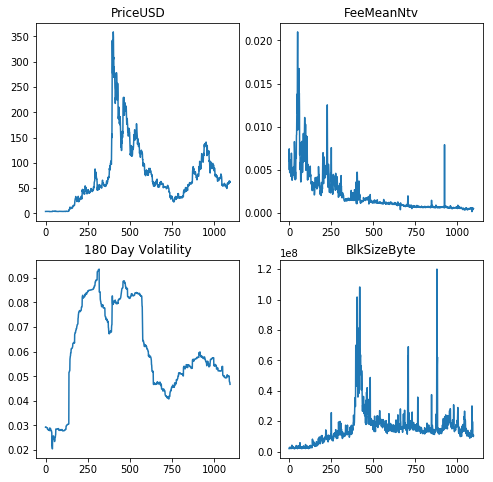

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
N=len(ltc_3yr_df)
ind = np.arange(N)

ax = axes[0,0]
ax.plot(ind, ltc_3yr_df['PriceUSD'])
ax.set_title('PriceUSD')

ax = axes[0,1]
ax.plot(ind, ltc_3yr_df['FeeMeanNtv'])
ax.set_title('FeeMeanNtv')

ax = axes[1,0]
ax.plot(ind, ltc_3yr_df['VtyDayRet180d'])
ax.set_title('180 Day Volatility')

ax = axes[1,1]
ax.plot(ind, ltc_3yr_df['BlkSizeByte'])
ax.set_title('BlkSizeByte')

plt.show()

In [5]:
ltc_3yr_df = ltc_3yr_df.drop(labels='date', axis=1)

In [6]:
ltc_3yr_df.shape

(1096, 39)

In [7]:
ltc_3yr_df.insert(39, 'Label', 0.0)

In [8]:
ltc_3yr_df.index = np.arange(len(ltc_3yr_df))

In [9]:
for i in range(len(ltc_3yr_df)):
    if i < (len(ltc_3yr_df)-1):
        ltc_3yr_df['Label'][i] = ltc_3yr_df['PriceUSD'][i+1]
    else:
        ltc_3yr_df['Label'][i] = ltc_3yr_df['PriceUSD'][i]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
ltc_3yr_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,...,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424,3.747908
1,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,...,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601,3.888318
2,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,...,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482,3.864308
3,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,...,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501,3.898460
4,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,...,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542,3.909259


In [130]:
X_df = pd.DataFrame(ltc_3yr_df.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(ltc_3yr_df['Label'])

In [17]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0, shuffle=True)

In [19]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [20]:
data_dir = 'Data/ltc_3yr'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [21]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [22]:
prefix = 'ltc-3yr-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [23]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [24]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [25]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2019-12-27 21:04:28 Starting - Starting the training job...
2019-12-27 21:04:29 Starting - Launching requested ML instances......
2019-12-27 21:05:34 Starting - Preparing the instances for training......
2019-12-27 21:06:33 Downloading - Downloading input data...
2019-12-27 21:07:27 Training - Training image download completed. Training in progress.
2019-12-27 21:07:27 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:07:24] 986x39 matrix with 38454 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delim


2019-12-27 21:07:34 Completed - Training job completed
Training seconds: 61
Billable seconds: 61


In [26]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [27]:
xgb_transformer.wait()

......................[2019-12-27 21:16:06 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-27 21:16:06 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-27 21:16:06 +0000] [15] [INFO] Using worker: gevent
[2019-12-27 21:16:06 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-27 21:16:06 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-27 21:16:06 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-27 21:16:06 +0000] [25] [INFO] Booting worker with pid: 25

[2019-12-27:21:16:27:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:21:16:27 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-27:21:16:27:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:21:16:27 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-27:21:16:27:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:21:16:27 +0000] "GET 

In [30]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2019-12-27-21-12-40-778/test.csv.out to Data/ltc_3yr/test.csv.out


In [31]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

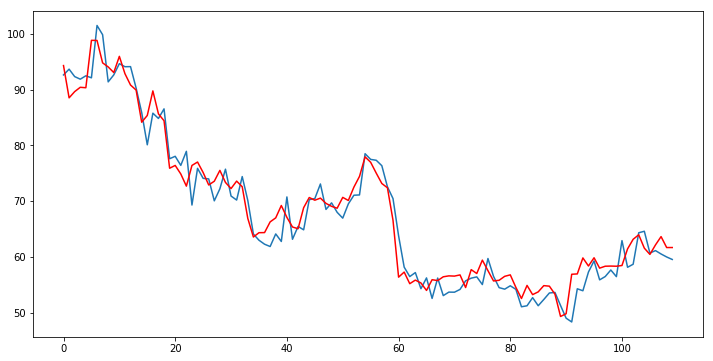

In [32]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.show()

In [38]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 2.3198672775281417.


In [39]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $18772.92
Investing $18772.92
Holding $18756.49
Investing $18756.49
Holding $18753.08
Investing $18753.08
Holding $19130.93
Investing $19130.93
Holding $18711.24
Investing $18711.24
Holding $19677.48
Investing $19677.48
Holding $19395.66
Investing $19395.66
Holding $19524.49
Investing $19524.49
Holding $18955.44
Investing $18955.44
Holding $19107.00
Investing $19107.00
Holding $19050.30
Investing $19050.30
Holding $18787.91
Investing $18787.91
Holding $18992.26
Investing $18992.26
Holding $18408.25
Investing $18408.25
Holding $18320.16
Investing $18320.16
Holding $18775.93
Investing $18775.93
Holding $18632.56
Investing $18632.56
Holding $20548.60
Investing $20548.60
Holding $20788.75
Investing $20788.75
Holding $20285.87
Investing $20285.87
Holding $20227.36
Investing $20227.36
Holding $20286.94
Investing $20286.94
Holding $20453.18
Investing $20453.18
Holding $19804.81
Investing $19804.81
Holding $19896.72
Investing $19896.72
Holding $20160.57
Investing $2

# Increasing Number of Training Rounds to 220

In [11]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0, shuffle=True)

In [12]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [13]:
data_dir = 'Data/ltc_220r'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [14]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [15]:
prefix = 'ltc-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [17]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [18]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=220)

In [19]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2020-01-03 21:14:20 Starting - Starting the training job...
2020-01-03 21:14:21 Starting - Launching requested ML instances......
2020-01-03 21:15:50 Starting - Preparing the instances for training......
2020-01-03 21:16:42 Downloading - Downloading input data...
2020-01-03 21:17:02 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:17:30] 986x39 matrix with 38454 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 986 rows
[21:17:30] WARNING: /wo


2020-01-03 21:17:41 Uploading - Uploading generated training model
2020-01-03 21:17:41 Completed - Training job completed
Training seconds: 59
Billable seconds: 59


In [20]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [21]:
xgb_transformer.wait()

.......................[2020-01-03 21:23:14 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-01-03 21:23:14 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-01-03 21:23:14 +0000] [15] [INFO] Using worker: gevent
[2020-01-03 21:23:14 +0000] [22] [INFO] Booting worker with pid: 22
[2020-01-03 21:23:14 +0000] [23] [INFO] Booting worker with pid: 23
[2020-01-03 21:23:14 +0000] [24] [INFO] Booting worker with pid: 24
[2020-01-03 21:23:14 +0000] [25] [INFO] Booting worker with pid: 25

[2020-01-03:21:23:35:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:21:23:35 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-03:21:23:35:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:21:23:35 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-01-03:21:23:35:INFO] No GPUs detected (normal if no gpus installed)
[2020-01-03:21:23:35:INFO] Determined delimiter of CS

In [22]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2020-01-03-21-19-48-188/test.csv.out to Data/ltc_220r/test.csv.out


In [23]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

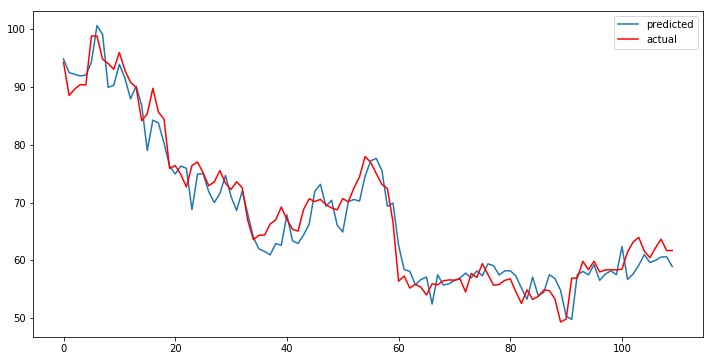

In [24]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [26]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 2.4215714033680995.


In [27]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $21858.57
Investing $21858.57
Holding $22298.99
Investing $22298.99
Holding $22077.96
Investing $22077.96
Holding $23218.05
Investing $23218.05
Holding $22752.61
Investing $22752.61
Holding $22375.30
Investing $22375.30
Holding $22308.90
Investing $22308.90
Holding $22001.63
Investing $22001.63
Holding $22240.93
Investing $22240.93
Holding $21557.03
Investing $21557.03
Holding $23374.98
Investing $23374.98
Holding $23196.49
Investing $23196.49
Holding $23801.21
Investing $23801.21
Holding $23987.38
Investing $23987.38
Holding $22054.88
Investing $22054.88
Holding $21322.47
Investing $21322.47
Holding $21260.98
Investing $21260.98
Holding $20535.41
Investing $20535.41
Holding $20287.46
Investing $20287.46
Holding $19644.35
Investing $19644.35
Holding $19986.63
Investing $19986.63
Holding $19386.01
Investing $19386.01
Holding $19756.04
Investing $19756.04
Holding $20773.24
Investing $20773.24
Holding $21298.46
Investing $21298.46
Holding $21435.29
Investing $2

# Without Shuffling Train Dataset

In [133]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)

In [134]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [135]:
data_dir = 'Data/ltc_3yr_no_shuff'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [136]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [137]:
prefix = 'ltc-3yr-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [138]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [139]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [140]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2020-01-04 01:09:12 Starting - Starting the training job...
2020-01-04 01:09:14 Starting - Launching requested ML instances.........
2020-01-04 01:10:50 Starting - Preparing the instances for training......
2020-01-04 01:12:04 Downloading - Downloading input data
2020-01-04 01:12:04 Training - Downloading the training image...
2020-01-04 01:12:42 Uploading - Uploading generated training model
2020-01-04 01:12:42 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:12:32] 986x39 matrix with 38454 entries loaded from /opt/ml/input/data/train

Training seconds: 58
Billable seconds: 58


In [141]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [142]:
xgb_transformer.wait()

......................[2020-01-04 01:16:36 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-01-04 01:16:36 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-01-04 01:16:36 +0000] [15] [INFO] Using worker: gevent
[2020-01-04 01:16:36 +0000] [22] [INFO] Booting worker with pid: 22
[2020-01-04 01:16:36 +0000] [23] [INFO] Booting worker with pid: 23
[2020-01-04 01:16:36 +0000] [27] [INFO] Booting worker with pid: 27
[2020-01-04 01:16:36 +0000] [28] [INFO] Booting worker with pid: 28

[2020-01-04:01:16:56:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Jan/2020:01:16:56 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-04:01:16:56:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Jan/2020:01:16:56 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-01-04:01:16:57:INFO] No GPUs detected (normal if no gpus installed)
[2020-01-04:01:16:56:INFO] No GPUs detected (normal if

In [143]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2020-01-04-01-13-09-744/test.csv.out to Data/ltc_3yr_no_shuff/test.csv.out


In [144]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

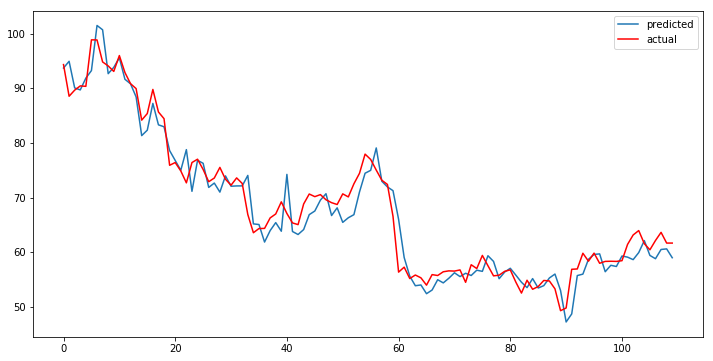

In [145]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [27]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 2.224258903086755.


In [28]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $18772.92
Investing $18772.92
Holding $20517.45
Investing $20517.45
Holding $20930.86
Investing $20930.86
Holding $22327.11
Investing $22327.11
Holding $21676.37
Investing $21676.37
Holding $21849.69
Investing $21849.69
Holding $22051.07
Investing $22051.07
Holding $21419.60
Investing $21419.60
Holding $19831.79
Investing $19831.79
Holding $20645.44
Investing $20645.44
Holding $20010.61
Investing $20010.61
Holding $21408.57
Investing $21408.57
Holding $21305.12
Investing $21305.12
Holding $22614.35
Investing $22614.35
Holding $22405.36
Investing $22405.36
Holding $23137.56
Investing $23137.56
Holding $23188.77
Investing $23188.77
Holding $22264.00
Investing $22264.00
Holding $21995.18
Investing $21995.18
Holding $21297.93
Investing $21297.93
Holding $21669.03
Investing $21669.03
Holding $21017.85
Investing $21017.85
Holding $20856.62
Investing $20856.62
Holding $24278.46
Investing $24278.46
Holding $24289.26
Investing $24289.26
Holding $24342.92
Investing $2

# Increasing Rounds Trained to 220 and Without Shuffling Training Set

In [146]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)

In [147]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'
assert X_test['PriceUSD'][999] == Y_test['Label'][998], \
    'Test values aren\'t matching'
assert X_train['PriceUSD'][22] == Y_train['Label'][21], \
    'Train values aren\'t matching'

print('Tests Passed!')    

Tests Passed!


In [148]:
data_dir = 'Data/ltc_3yr_no_shuff'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [149]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [150]:
prefix = 'ltc-3yr-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [151]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [152]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=220)

In [153]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2020-01-04 01:20:19 Starting - Starting the training job...
2020-01-04 01:20:21 Starting - Launching requested ML instances......
2020-01-04 01:21:27 Starting - Preparing the instances for training......
2020-01-04 01:22:35 Downloading - Downloading input data...
2020-01-04 01:22:53 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:23:23] 986x39 matrix with 38454 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 986 rows
[0]#011train-rmse


2020-01-04 01:23:33 Uploading - Uploading generated training model
2020-01-04 01:23:33 Completed - Training job completed
Training seconds: 58
Billable seconds: 58


In [154]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [155]:
xgb_transformer.wait()

......................[2020-01-04 01:35:18 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-01-04 01:35:18 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-01-04 01:35:18 +0000] [15] [INFO] Using worker: gevent
[2020-01-04 01:35:18 +0000] [22] [INFO] Booting worker with pid: 22
[2020-01-04 01:35:18 +0000] [23] [INFO] Booting worker with pid: 23
[2020-01-04 01:35:18 +0000] [24] [INFO] Booting worker with pid: 24
[2020-01-04 01:35:18 +0000] [28] [INFO] Booting worker with pid: 28

[2020-01-04:01:35:45:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Jan/2020:01:35:45 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-04:01:35:45:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [04/Jan/2020:01:35:45 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-01-04:01:35:45:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [04/Jan/2020:01:35:45 +0000] "POST /invo

In [156]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2020-01-04-01-31-48-244/test.csv.out to Data/ltc_3yr_no_shuff/test.csv.out


In [157]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

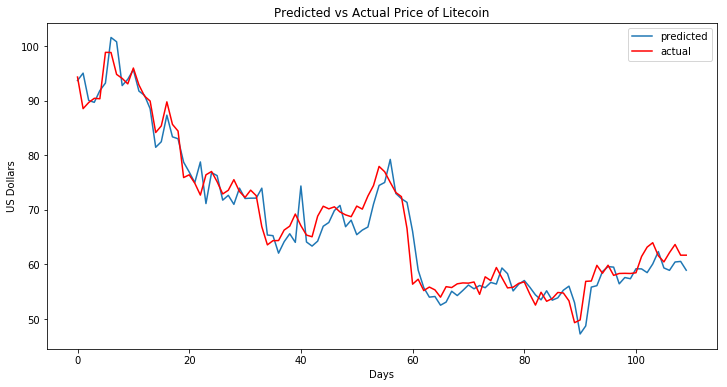

In [159]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.title('Predicted vs Actual Price of Litecoin')
plt.xlabel('Days')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

In [41]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 2.210752746928402.


In [42]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $18772.92
Investing $18772.92
Holding $20517.45
Investing $20517.45
Holding $20930.86
Investing $20930.86
Holding $22327.11
Investing $22327.11
Holding $21676.37
Investing $21676.37
Holding $21849.69
Investing $21849.69
Holding $22051.07
Investing $22051.07
Holding $21419.60
Investing $21419.60
Holding $19831.79
Investing $19831.79
Holding $20645.44
Investing $20645.44
Holding $20010.61
Investing $20010.61
Holding $21408.57
Investing $21408.57
Holding $21305.12
Investing $21305.12
Holding $22614.35
Investing $22614.35
Holding $22405.36
Investing $22405.36
Holding $23137.56
Investing $23137.56
Holding $23188.77
Investing $23188.77
Holding $22264.00
Investing $22264.00
Holding $21995.18
Investing $21995.18
Holding $21297.93
Investing $21297.93
Holding $21669.03
Investing $21669.03
Holding $21017.85
Investing $21017.85
Holding $20856.62
Investing $20856.62
Holding $25057.34
Investing $25057.34
Holding $25068.48
Investing $25068.48
Holding $25123.87
Investing $2

# Testing Robustness by Predicting and Comparing on Year of Unseen Data

In [57]:
ltc_new_old_test = ltc_df[766:1132]

In [61]:
ltc_new_old_test.index = np.arange(len(ltc_new_old_test))

In [62]:
ltc_new_old_test.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
0,2013-11-11,13211,594,4020692,6768.841751,1.786454,9.186513e+07,5.142319e+07,1259.796797,0.016713,...,1.722605e+06,49.243028,197.366056,4.000000,16.032000,5.815602e+05,2.330893e+06,0.078661,0.085861,0.077049
1,2013-11-12,15326,556,5132515,9231.142086,1.800103,9.300849e+07,5.166842e+07,1259.796797,0.026094,...,1.628556e+06,48.456192,196.391405,3.252175,13.180960,5.609289e+05,2.273427e+06,0.075477,0.085575,0.076966
2,2013-11-13,16999,554,7086585,12791.669675,1.820409,9.517656e+07,5.228305e+07,1259.796797,0.027942,...,2.274299e+06,59.247993,245.431519,4.000000,16.569778,8.211772e+05,3.401681e+06,0.067285,0.084684,0.076978
3,2013-11-14,15566,583,5328687,9140.114923,1.842818,9.855053e+07,5.347817e+07,1242.392378,0.023906,...,3.740000e+06,80.662517,345.546723,3.212938,13.763769,1.165331e+06,4.992114e+06,0.066216,0.084247,0.077043
4,2013-11-15,15242,613,3832475,6251.998369,1.715944,9.326407e+07,5.435148e+07,1238.069225,0.016364,...,3.136883e+06,7968.250087,32260.799384,4.000000,16.194672,1.416675e+08,5.735648e+08,0.065962,0.084675,0.077473


In [63]:
ltc_new_old_test = ltc_new_old_test.drop(labels='date', axis=1)

In [64]:
ltc_new_old_test.shape

(366, 39)

In [65]:
ltc_new_old_test.insert(39, 'Label', 0.0)

In [67]:
for i in range(len(ltc_new_old_test)):
    if i < (len(ltc_new_old_test)-1):
        ltc_new_old_test['Label'][i] = ltc_new_old_test['PriceUSD'][i+1]
    else:
        ltc_new_old_test['Label'][i] = ltc_new_old_test['PriceUSD'][i]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
X_df = pd.DataFrame(ltc_new_old_test.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(ltc_new_old_test['Label'])

In [69]:
data_dir = 'Data/ltc_test'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [70]:
X_df.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

In [71]:
prefix = 'ltc-3yr-test'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [72]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [73]:
xgb_transformer.wait()

.......................[2020-01-03 23:10:55 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-01-03 23:10:55 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-01-03 23:10:55 +0000] [15] [INFO] Using worker: gevent
[2020-01-03 23:10:55 +0000] [22] [INFO] Booting worker with pid: 22
[2020-01-03 23:10:55 +0000] [23] [INFO] Booting worker with pid: 23
[2020-01-03 23:10:55 +0000] [27] [INFO] Booting worker with pid: 27
[2020-01-03 23:10:55 +0000] [31] [INFO] Booting worker with pid: 31

[2020-01-03:23:11:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:23:11:15 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-03:23:11:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:23:11:15 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-03:23:11:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:23:11:15 +0000] "GET /execution-param

In [74]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2020-01-03-23-07-26-329/test.csv.out to Data/ltc_test/test.csv.out


In [75]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

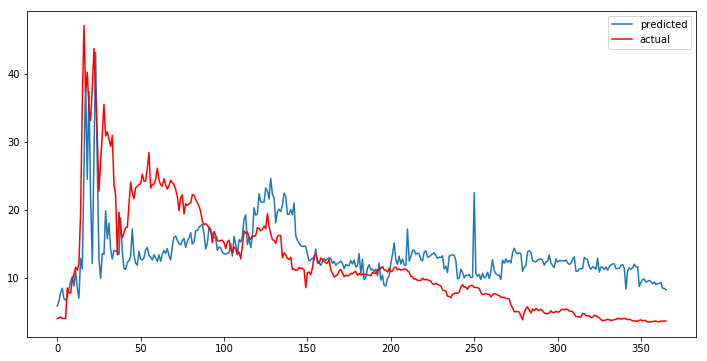

In [79]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_df, color='r', label='actual')
plt.legend()
plt.show()

In [80]:
helpers.get_test_loss(Y_pred, Y_df)

Test loss is 5.238645655365353.


In [82]:
helpers.roi_display(20000, Y_pred, Y_df)

Investing $20000.00
Holding $19978.78
Investing $19978.78
Holding $47716.29
Investing $47716.29
Holding $52314.12
Investing $52314.12
Holding $84582.05
Investing $84582.05
Holding $89047.04
Investing $89047.04
Holding $77228.77
Investing $77228.77
Holding $76276.96
Investing $76276.96
Holding $87870.17
Investing $87870.17
Holding $76340.70
Investing $76340.70
Holding $73834.91
Investing $73834.91
Holding $56695.42
Investing $56695.42
Holding $34265.15
Investing $34265.15
Holding $29177.75
Investing $29177.75
Holding $37518.39
Investing $37518.39
Holding $37970.13
Investing $37970.13
Holding $39313.07
Investing $39313.07
Holding $39364.56
Investing $39364.56
Holding $36817.40
Investing $36817.40
Holding $38213.62
Investing $38213.62
Holding $37212.76
Investing $37212.76
Holding $35118.15
Investing $35118.15
Holding $31312.07
Investing $31312.07
Holding $31524.51
Investing $31524.51
Holding $25944.89
Investing $25944.89
Holding $25009.49
Investing $25009.49
Holding $24785.07
Investing $2

# Now Testing Robustness with Bitcoin

In [83]:
btc_df = pd.read_csv('Data/btc.csv')

In [88]:
x_labels = [btc_df['date'][0],btc_df['date'][365],btc_df['date'][365*2],btc_df['date'][365*3],btc_df['date'][365*4], \
           btc_df['date'][365*5],btc_df['date'][365*6],btc_df['date'][365*7],btc_df['date'][365*8],btc_df['date'][365*9], \
           btc_df['date'][365*10],btc_df['date'][365*11]]

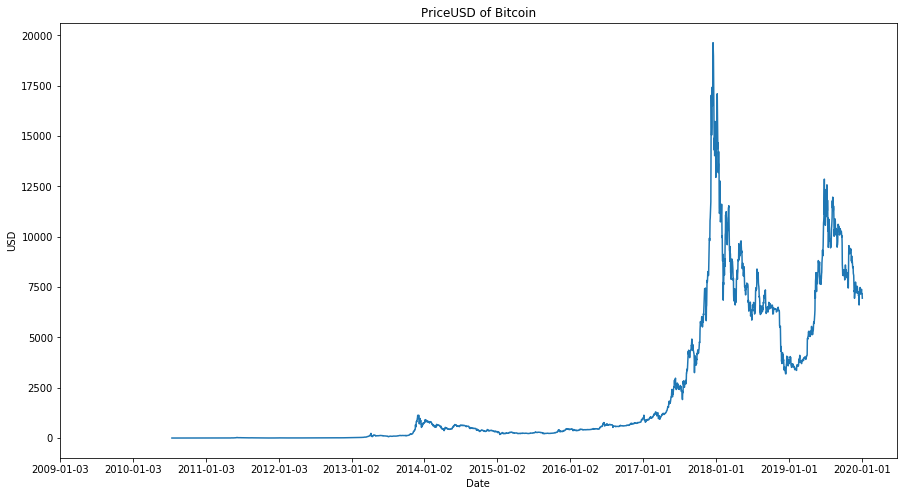

In [89]:
plt.figure(figsize=(15,8))
plt.plot(btc_df.index, btc_df['PriceUSD'])
plt.title('PriceUSD of Bitcoin')
plt.xticks(np.arange(len(btc_df), step=365), labels = x_labels)
plt.xlabel('Date')
plt.ylabel('USD')
plt.show()

In [96]:
btc_test = btc_df[3650:4015]

In [98]:
btc_test.index = np.arange(len(btc_test))

In [99]:
btc_test.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
0,2019-01-01,433715,149,120384440,807949.261745,0.839104,6.648014e+10,7.922758e+10,5.618596e+12,0.000048,...,5.530820e+08,0.859115,3271.611590,0.011942,45.47521,385535.640068,1.468165e+09,0.035933,0.045371,0.049908
1,2019-01-02,578607,151,142187231,941637.291391,0.859073,6.806006e+10,7.922500e+10,5.618596e+12,0.000067,...,9.763451e+08,1.194868,4657.833169,0.015370,59.91588,651958.459166,2.541463e+09,0.035975,0.044061,0.050072
2,2019-01-03,598436,155,149073486,961764.425806,0.834871,6.608036e+10,7.915035e+10,5.618596e+12,0.000066,...,1.077510e+09,1.156989,4378.495227,0.015000,56.76583,693368.340948,2.623975e+09,0.035985,0.044333,0.050064
3,2019-01-04,580495,149,142981222,959605.516779,0.844726,6.684070e+10,7.912703e+10,5.618596e+12,0.000068,...,1.172601e+09,1.263071,4834.436287,0.014146,54.14267,734895.273515,2.812830e+09,0.036001,0.043466,0.050126
4,2019-01-05,519070,163,134492012,825104.368098,0.838567,6.634357e+10,7.911544e+10,5.618596e+12,0.000047,...,7.749182e+08,1.031904,3919.803477,0.012968,49.26166,550383.336107,2.090694e+09,0.036002,0.042214,0.050090


In [100]:
btc_test = btc_test.drop(labels='date', axis=1)

In [101]:
btc_test.shape

(365, 39)

In [102]:
btc_test.insert(39, 'Label', 0.0)

In [103]:
for i in range(len(btc_test)):
    if i < (len(btc_test)-1):
        btc_test['Label'][i] = btc_test['PriceUSD'][i+1]
    else:
        btc_test['Label'][i] = btc_test['PriceUSD'][i]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
X_df = pd.DataFrame(btc_test.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(btc_test['Label'])

In [105]:
data_dir = 'Data/btc_test'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [106]:
X_df.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

In [107]:
prefix = 'btc-test'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [108]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [109]:
xgb_transformer.wait()

........................[2020-01-03 23:38:22 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-01-03 23:38:22 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-01-03 23:38:22 +0000] [15] [INFO] Using worker: gevent
[2020-01-03 23:38:22 +0000] [22] [INFO] Booting worker with pid: 22
[2020-01-03 23:38:22 +0000] [23] [INFO] Booting worker with pid: 23
[2020-01-03 23:38:22 +0000] [27] [INFO] Booting worker with pid: 27
[2020-01-03 23:38:22 +0000] [28] [INFO] Booting worker with pid: 28

[2020-01-03:23:38:50:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:23:38:50 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-03:23:38:50:INFO] No GPUs detected (normal if no gpus installed)
[2020-01-03:23:38:50:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [03/Jan/2020:23:38:50 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-01-03:23:38:50:INFO] No GPUs detected (normal if no gpus instal

In [110]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2020-01-03-23-34-33-288/test.csv.out to Data/btc_test/test.csv.out


In [111]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

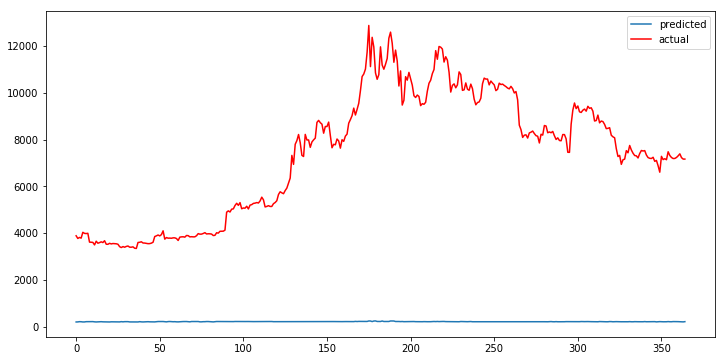

In [112]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_df, color='r', label='actual')
plt.legend()
plt.show()

In [113]:
helpers.get_test_loss(Y_pred, Y_df)

Test loss is 7136.497274056935.


In [114]:
helpers.roi_display(20000, Y_pred, Y_df)

Investing $20000.00
Holding $19637.41
Investing $19637.41
Holding $19434.85
Investing $19434.85
Holding $19396.56
Investing $19396.56
Holding $19254.72
Investing $19254.72
Holding $19240.08
Investing $19240.08
Holding $19103.39
Investing $19103.39
Holding $18999.06
Investing $18999.06
Holding $18782.09
Investing $18782.09
Holding $18630.40
Investing $18630.40
Holding $18721.72
Investing $18721.72
Holding $18712.76
Investing $18712.76
Holding $18390.77
Investing $18390.77
Holding $19827.45
Investing $19827.45
Holding $19747.20
Investing $19747.20
Holding $20081.68
Investing $20081.68
Holding $20904.88
Investing $20904.88
Holding $20781.06
Investing $20781.06
Holding $20775.67
Investing $20775.67
Holding $21967.77
Investing $21967.77
Holding $22009.67
Investing $22009.67
Holding $22505.38
Investing $22505.38
Holding $22557.18
Investing $22557.18
Holding $23242.68
Investing $23242.68
Holding $27583.26
Investing $27583.26
Holding $28374.81
Investing $28374.81
Holding $29009.21
Investing $2

In [120]:
.35*20000

7000.0

# Dropping PriceBTC

I'm more concerened about the price in USD. Judging by the graphs below, this feature looks pretty noisy.

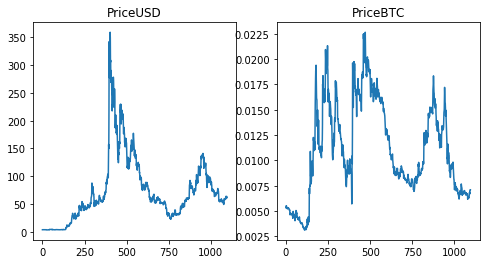

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
N=len(ltc_3yr_df)
ind = np.arange(N)

ax = axes[0]
ax.plot(ind, ltc_3yr_df['PriceUSD'])
ax.set_title('PriceUSD')

ax = axes[1]
ax.plot(ind, ltc_3yr_df['PriceBTC'])
ax.set_title('PriceBTC')

plt.show()

In [14]:
ltc_3yr_df = ltc_3yr_df.drop(labels='PriceBTC', axis=1)

In [15]:
ltc_3yr_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,...,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424,3.747908
1,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,...,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601,3.888318
2,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,...,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482,3.864308
3,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,...,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501,3.898460
4,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,...,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542,3.909259


In [16]:
X_df = pd.DataFrame(ltc_3yr_df.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(ltc_3yr_df['Label'])

In [17]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)

In [18]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'

print('Tests Passed!')    

Tests Passed!


In [19]:
data_dir = 'Data/ltc_3yr_noBTC'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [20]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [21]:
prefix = 'ltc-3yr-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [22]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [23]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [24]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2019-12-27 21:52:03 Starting - Starting the training job...
2019-12-27 21:52:04 Starting - Launching requested ML instances.........
2019-12-27 21:53:33 Starting - Preparing the instances for training...
2019-12-27 21:54:24 Downloading - Downloading input data...
2019-12-27 21:54:44 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:55:13] 986x38 matrix with 37468 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 986 rows
[0]#011train-rmse


2019-12-27 21:55:23 Uploading - Uploading generated training model
2019-12-27 21:55:23 Completed - Training job completed
Training seconds: 59
Billable seconds: 59


In [25]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [26]:
xgb_transformer.wait()

......................[2019-12-27 21:59:38 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-27 21:59:38 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-27 21:59:38 +0000] [15] [INFO] Using worker: gevent
[2019-12-27 21:59:38 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-27 21:59:38 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-27 21:59:38 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-27 21:59:38 +0000] [28] [INFO] Booting worker with pid: 28
[2019-12-27:21:59:59:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:21:59:59 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-27:21:59:59:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:21:59:59 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-27:22:00:00:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-27:22:00:00:INFO] Determined delimiter of CSV 

In [27]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2019-12-27-21-56-17-248/test.csv.out to Data/ltc_3yr_noBTC/test.csv.out


In [28]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

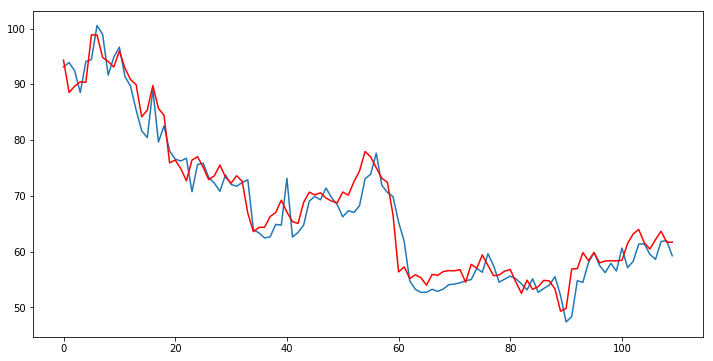

In [29]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.show()

In [30]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 2.4102110135915567.


In [31]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $18772.92
Investing $18772.92
Holding $20517.45
Investing $20517.45
Holding $20930.86
Investing $20930.86
Holding $22011.71
Investing $22011.71
Holding $21696.47
Investing $21696.47
Holding $21064.11
Investing $21064.11
Holding $20714.80
Investing $20714.80
Holding $20121.60
Investing $20121.60
Holding $18291.84
Investing $18291.84
Holding $19042.31
Investing $19042.31
Holding $18456.76
Investing $18456.76
Holding $19812.98
Investing $19812.98
Holding $19548.57
Investing $19548.57
Holding $19395.00
Investing $19395.00
Holding $20063.79
Investing $20063.79
Holding $20276.76
Investing $20276.76
Holding $20738.83
Investing $20738.83
Holding $20081.41
Investing $20081.41
Holding $20431.31
Investing $20431.31
Holding $19817.33
Investing $19817.33
Holding $19665.31
Investing $19665.31
Holding $22482.99
Investing $22482.99
Holding $22493.15
Investing $22493.15
Holding $22503.15
Investing $22503.15
Holding $22552.87
Investing $22552.87
Holding $22604.10
Investing $2

# Dropping some features

- BlkSizeMeanByte: because it is the calculated with BlkCnt and BlkSizeByte and therefore redundant
- CapMVRVCur: beacuase it is the ratio of CapMrktCurUSD and CapRealUSD
- FeeMedUSD: because there is also the FeeMeanUSD 
- IssContNtv: because it only includes those native units that are issued by a protocol-mandated continuous emission schedule and IssTotUSD includes all new native units issued
- NVTAdj: because NVTAdj defined as the ratio of the network value (or market capitalization, current supply) divided by the adjusted transfer value. Also referred to as NVT. This is too similar to NVTAdj90 that just moves the ratio of the network value to the 90 day average, and is still divided by the adjusted transfer value
- TxTfrValAdjNtv, TxTfrValAdjUSD: because TxTr is the sum count of transfers that day without removing anything and/or converting to USD
- TxTfrValMeanUSD: again TxTfrValMeanNtv already has this covered without converting to USD and providing more redundancy
- TxTfrValMedNtv, TxTfrValMedUSD: again trying to cut out redundancy and relying on the mean to sum up this metric.
- TxTfrValUSD, TxTfrValNtv: as the sum of native units transferred (i.e., the aggregate "size" of all transfers) that day, this metric can be inferred with the metrics TxTfr and TxTfrValMeanNtv
- VtyDayRet180d, VtyDayRet60d: more focused on short term, daily movement

In [32]:
drop_labels = ['BlkSizeMeanByte', 'CapMVRVCur', 'CapMVRVCur', 'FeeMedUSD', 'IssContNtv', 'NVTAdj', 'TxTfrValAdjNtv', \
               'TxTfrValAdjUSD', 'TxTfrValMeanUSD', 'TxTfrValMedNtv', 'TxTfrValMedUSD', 'TxTfrValUSD', 'TxTfrValNtv', \
               'VtyDayRet180d', 'VtyDayRet60d']

In [33]:
ltc_3yr_df = ltc_3yr_df.drop(labels=drop_labels, axis=1)

In [34]:
ltc_3yr_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeTotNtv,...,NVTAdj90,PriceUSD,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrCnt,TxTfrValMeanNtv,VtyDayRet30d,Label
0,7301,638,1962084,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,0.001,19.255942,...,50.699191,3.811654,15.994183,0.124997,4.839710e+07,3186,8867,147.744617,0.016593,3.747908
1,10630,576,2417247,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,0.001,23.452002,...,50.053204,3.747908,15.801496,-3.644648,4.841150e+07,3164,10886,233.870536,0.016358,3.888318
2,15468,561,2550985,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,0.001,19.019734,...,51.880243,3.888318,21.823176,0.064731,4.842553e+07,3824,17696,339.766758,0.017770,3.864308
3,13481,605,2800901,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,0.001,20.557782,...,51.674524,3.864308,25.628170,-0.302445,4.844065e+07,3405,13041,234.939070,0.017801,3.898460
4,10544,588,2694323,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,0.001,17.689135,...,52.069229,3.898460,21.857534,0.151176,4.845535e+07,3810,11190,392.344821,0.017859,3.909259


In [35]:
ltc_3yr_df.columns.values

array(['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'CapMrktCurUSD',
       'CapRealUSD', 'DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv',
       'FeeTotNtv', 'FeeTotUSD', 'IssContPctAnn', 'IssContUSD',
       'IssTotNtv', 'IssTotUSD', 'NVTAdj90', 'PriceUSD', 'ROI1yr',
       'ROI30d', 'SplyCur', 'TxCnt', 'TxTfrCnt', 'TxTfrValMeanNtv',
       'VtyDayRet30d', 'Label'], dtype=object)

In [36]:
X_df = pd.DataFrame(ltc_3yr_df.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(ltc_3yr_df['Label'])

In [45]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)

In [46]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'

print('Tests Passed!')    

Tests Passed!


In [47]:
data_dir = 'Data/ltc_3yr_reduced_dimensions'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [48]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [49]:
prefix = 'ltc-3yr-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [50]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [51]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=200)

In [52]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2019-12-27 22:02:58 Starting - Starting the training job...
2019-12-27 22:03:00 Starting - Launching requested ML instances......
2019-12-27 22:04:04 Starting - Preparing the instances for training......
2019-12-27 22:05:09 Downloading - Downloading input data...
2019-12-27 22:05:56 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:05:58] 986x24 matrix with 23664 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 9


2019-12-27 22:06:09 Uploading - Uploading generated training model
2019-12-27 22:06:09 Completed - Training job completed
Training seconds: 60
Billable seconds: 60


In [53]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [54]:
xgb_transformer.wait()

......................[2019-12-27 22:13:51 +0000] [20] [INFO] Starting gunicorn 19.10.0
[2019-12-27 22:13:51 +0000] [20] [INFO] Listening at: unix:/tmp/gunicorn.sock (20)
[2019-12-27 22:13:51 +0000] [20] [INFO] Using worker: gevent
[2019-12-27 22:13:51 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-27 22:13:51 +0000] [28] [INFO] Booting worker with pid: 28
[2019-12-27 22:13:52 +0000] [32] [INFO] Booting worker with pid: 32
[2019-12-27 22:13:52 +0000] [33] [INFO] Booting worker with pid: 33
[2019-12-27:22:14:10:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:22:14:10 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [27/Dec/2019:22:14:10 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-27:22:14:11:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-27:22:14:11:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [27/Dec/2019:22:14:11 +0000] "POST /invoc

In [55]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2019-12-27-22-10-28-528/test.csv.out to Data/ltc_3yr_reduced_dimensions/test.csv.out


In [56]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

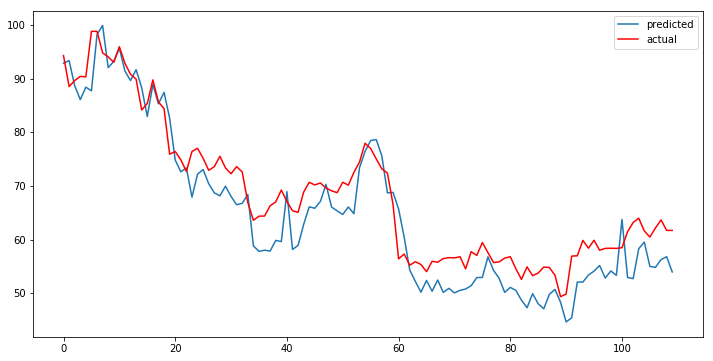

In [57]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [58]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 4.442157776963763.


In [59]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $18772.92
Investing $18772.92
Holding $18756.49
Investing $18756.49
Holding $17990.26
Investing $17990.26
Holding $18352.74
Investing $18352.74
Holding $18170.83
Investing $18170.83
Holding $19109.16
Investing $19109.16
Holding $18835.48
Investing $18835.48
Holding $18286.51
Investing $18286.51
Holding $17983.26
Investing $17983.26
Holding $17468.28
Investing $17468.28
Holding $15879.80
Investing $15879.80
Holding $15884.94
Investing $15884.94
Holding $16057.71
Investing $16057.71
Holding $15563.94
Investing $15563.94
Holding $16822.06
Investing $16822.06
Holding $16685.12
Investing $16685.12
Holding $16554.04
Investing $16554.04
Holding $17124.87
Investing $17124.87
Holding $15745.24
Investing $15745.24
Holding $15364.36
Investing $15364.36
Holding $15320.05
Investing $15320.05
Holding $15365.17
Investing $15365.17
Holding $15631.15
Investing $15631.15
Holding $15703.69
Investing $15703.69
Holding $15231.78
Investing $15231.78
Holding $14806.76
Investing $1